In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from igraph import Graph

# Pkt 3, 4
## Wczytanie danych

In [2]:
df = pd.read_csv(
    "input/out.radoslaw_email_email",
    sep=r"\s+",
    header=None,
    skiprows=2,
    engine="python"
)

df = df.iloc[:, :2]
df.columns = ["source", "target"]

print(df)


       source  target
0           1       2
1           1       3
2           1       4
3           1       5
4           1       6
...       ...     ...
82922       3      39
82923       3      39
82924      19      18
82925      85       3
82926      85      94

[82927 rows x 2 columns]


In [3]:
print("Min:", df[["source","target"]].min().min())
print("Max:", df[["source","target"]].max().max())
print("Unikalne ID:", len(pd.unique(df[["source","target"]].values.ravel())))
missing = set(range(1,168)) - set(pd.unique(df[["source","target"]].values.ravel()))
print("Brakujące numery:", missing)


Min: 1
Max: 167
Unikalne ID: 167
Brakujące numery: set()


## Stworzenie grafu skierowanego

In [4]:
# igraph wymaga etykiet jako string
df["source"] = df["source"].astype(str)
df["target"] = df["target"].astype(str)

# Tworzymy graf z zachowaniem ID jako 'name'
edges = list(df.itertuples(index=False, name=None))
g = Graph.TupleList(edges, directed=True, vertex_name_attr="name")

print(g.summary())

IGRAPH DN-- 167 82927 -- 
+ attr: name (v)


# 5. Usunięcie pętli i wielokrotnych krawędzi

In [5]:
g.simplify(multiple=True, loops=True, combine_edges=None)

print("Po simplify():")
print(g.summary())


Po simplify():
IGRAPH DN-- 167 5783 -- 
+ attr: name (v)


# 6. Liczenie wag zgodnie z formułą

In [6]:
cnt_ij = df.groupby(["source", "target"]).size().reset_index(name="cnt_ij")
cnt_i = df.groupby("source").size().reset_index(name="cnt_i")
cnt_ij = cnt_ij.merge(cnt_i, on="source")

cnt_ij["weight"] = cnt_ij["cnt_ij"] / cnt_ij["cnt_i"]

weight_dict = {
    (str(row.source), str(row.target)): row.weight
    for row in cnt_ij.itertuples()
}

weights = []
for e in g.es:
    s = g.vs[e.source]["name"]  # string
    t = g.vs[e.target]["name"]  # string
    weights.append(weight_dict.get((s, t), 0.0))

g.es["weight"] = weights



## Sprawdzenie wag

In [7]:
check_sums = []
for v in g.vs:
    out_edges = g.es.select(_source=v.index)
    wsum = sum(out_edges["weight"])
    check_sums.append((v["name"], wsum))

print("Powinno wyjść 1 dla każdego węzła:")
print(check_sums[:10])

Powinno wyjść 1 dla każdego węzła:
[('1', 1.0), ('2', 1.0), ('3', 1.0), ('4', 1.0), ('5', 1.0), ('6', 1.0), ('7', 1.0), ('8', 1.0), ('9', 1.0), ('10', 1.0)]


# 7. Proces rozprzestrzeniania się informacji

In [8]:
num_simulations = 100
p = 0.05  # 5% węzłów
N = len(g.vs)
num_initial = int(round(p * N))


In [9]:
def independent_cascade_simulation(g, initial_set):
    g.vs["activated"] = [False] * N
    for v in initial_set:
        g.vs[v]["activated"] = True

    activated_counts = [len(initial_set)]
    current_front = set(initial_set)

    while len(current_front) > 0:
        next_front = set()
        attempted = set()

        for v in current_front:
            out_edges = g.es.select(_source=v)
            for e in out_edges:
                u = e.target
                if g.vs[u]["activated"]:
                    continue
                if u in attempted:
                    continue

                attempted.add(u)
                prob = e["weight"]
                if random.random() < prob:
                    g.vs[u]["activated"] = True
                    next_front.add(u)

        current_front = next_front
        activated_counts.append(sum(g.vs["activated"]))

    return activated_counts



# 8. Generowanie zestawów węzłów

In [10]:

# 1. Największy outdegree
outdeg = g.outdegree()
top_outdeg = sorted(range(N), key=lambda x: outdeg[x], reverse=True)[:num_initial]

# 2. Betweenness centrality
betw = g.betweenness()
top_betw = sorted(range(N), key=lambda x: betw[x], reverse=True)[:num_initial]

# 3. Closeness centrality
closeness = g.closeness()
top_close = sorted(range(N), key=lambda x: closeness[x], reverse=True)[:num_initial]

# 4. Losowe
top_random = random.sample(range(N), num_initial)

# 5. Miara własna: "weighted influence" = suma wag wychodzących z węzła
# im większa suma wag wychodzących, tym większy potencjał przesłania informacji
weighted_influence = [sum(g.es.select(_source=i)["weight"]) for i in range(N)]
top_weighted = sorted(range(N), key=lambda x: weighted_influence[x], reverse=True)[:num_initial]

seed_sets = {
    "top_outdegree": top_outdeg,
    "top_betweenness": top_betw,
    "top_closeness": top_close,
    "random": top_random,
    "top_weighted_influence": top_weighted
}

## Uruchamianie symulacji

In [11]:
def run_experiment(seed_nodes_dict):
    results = {}
    for key, nodes in seed_nodes_dict.items():
        all_runs = []
        for sim in range(num_simulations):
            # dla losowego seedowania za każdym razem tworzymy nowy losowy zestaw
            if key == "random":
                initial_set = random.sample(range(N), num_initial)
            else:
                initial_set = nodes
            run = independent_cascade_simulation(g, initial_set)
            all_runs.append(run)

        max_len = max(len(run) for run in all_runs)
        aligned = []
        for run in all_runs:
            if len(run) < max_len:
                run = run + [run[-1]] * (max_len - len(run))
            aligned.append(run)

        mean_curve = np.mean(aligned, axis=0)
        results[key] = mean_curve
    return results


In [12]:
mean_activation_curves = run_experiment(seed_sets)

for key, curve in mean_activation_curves.items():
    print(f"{key}: {curve[:10]} ...")


top_outdegree: [ 8.    9.    9.61  9.95 10.2  10.4  10.55 10.66 10.71 10.74] ...
top_betweenness: [ 8.    8.8   9.29  9.6   9.81  9.94 10.01 10.05 10.09 10.1 ] ...
top_closeness: [ 8.    8.93  9.67 10.05 10.31 10.45 10.52 10.6  10.63 10.63] ...
random: [ 8.   10.5  11.81 12.66 13.11 13.42 13.53 13.56 13.57 13.58] ...
top_weighted_influence: [8.   8.72 9.22 9.42 9.56 9.6  9.63 9.66 9.68 9.71] ...


# 9. Wykres

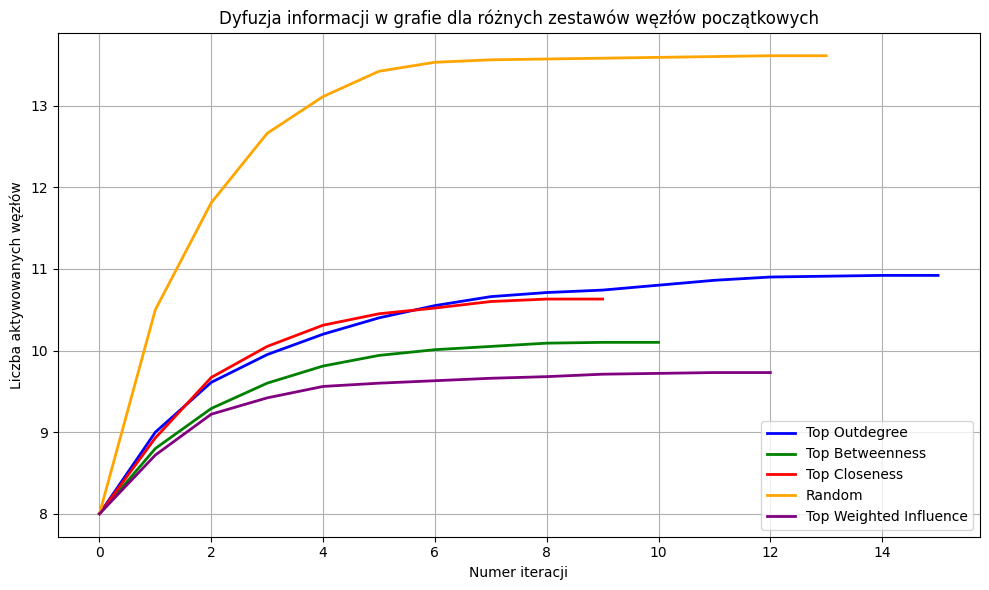

In [13]:
plt.figure(figsize=(10,6))

colors = ["blue", "green", "red", "orange", "purple"]
labels = ["Top Outdegree", "Top Betweenness", "Top Closeness", "Random", "Top Weighted Influence"]

for i, (key, curve) in enumerate(mean_activation_curves.items()):
    plt.plot(range(len(curve)), curve, color=colors[i], label=labels[i], linewidth=2)

plt.xlabel("Numer iteracji")
plt.ylabel("Liczba aktywowanych węzłów")
plt.title("Dyfuzja informacji w grafie dla różnych zestawów węzłów początkowych")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
